In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from itertools import cycle
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#기존 데이터
#association_data = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/9_gold_learning_association.tsv")
#descriptor_data = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_descriptor_combined.tsv", header=None) # 이거 현재 바뀜.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_descriptor_combined.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [7]:
#2017.3.15. removed TN descriptor
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/7_2_1_tn_whole_descriptor_removed.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [3]:
#2017.3.14. original TN descriptor
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/6_2_1_tn_whole_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [2]:
#2017.3.9.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_2_new_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [3]:
# new descriptor - TN 구분한 data(2017.1.16.) 수정됨. 2017.1.23.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_1%.tsv")
x_whole_data_1 = df[df.columns.values[3:].tolist()].values
y_whole_data_1 = df["association"].values

# new descriptor - TN 구분한 data(2017.1.16.) 수정됨. 2017.1.23. 추가됨 2017.2.1.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_0.5%.tsv")
x_whole_data_0_5 = df[df.columns.values[3:].tolist()].values
y_whole_data_0_5 = df["association"].values

df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_0.1%.tsv")
x_whole_data_0_1 = df[df.columns.values[3:].tolist()].values
y_whole_data_0_1 = df["association"].values

In [4]:
from sklearn.metrics import roc_curve, auc, average_precision_score
%matplotlib inline
def Random_Forest_10_fold(x_whole_data, y_whole_data, user_estimators):
    print("{}----------------------------------------------------\r\n".format(user_estimators))
    skf = StratifiedKFold(n_splits=10, shuffle=True) # n_splits = 10 (10 fold라서.) data가 nega : pos = 76 : 1이기 때문에 validation 뽑을때 그 비율 지켜서 stratified로 한다.
    whole_accuracy = list()
    whole_auc = list()
    whole_aupr = list()
    whole_confusion_mat = list()
    whole_precision = list()
    whole_recall = list()
    whole_sn = list()
    whole_sp = list()
    
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    lw = 2
    plt.clf()
    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    i=0
    
    for (training_index, validation_index), color in zip(skf.split(x_whole_data, y_whole_data), colors):
        
        x_training_set = x_whole_data[training_index] # 0.9에 해당하는 부분
        y_training_set = y_whole_data[training_index]
        x_validation_set = x_whole_data[validation_index] # 0.1에 해당하는 부분
        y_validation_set = y_whole_data[validation_index]

        #classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs=-1) #n_jobs = -1이면 모든 node 쓰는것. 신경쓰이면 30개 정도.
        classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
        #classifier = LinearSVC(penalty='l1', C=user_c, class_weight='balanced', dual=True, loss='hinge')
        classifier.fit(x_training_set, y_training_set)
        y_predicted_proba = classifier.predict_proba(x_validation_set) # return값이 probability 각각에 대한 확률 결과값 [[0.8(0에대한 확률),0.2(1에대한 확률)],[0.7,0.3],... ]
        y_predicted_label = classifier.predict(x_validation_set) # return이 label임. 위 확률 결과에서 확률이 높은거에 대한 label을 보여줌.

        current_accuracy = classifier.score(x_validation_set, y_validation_set) # accuracy score를 보여줌.
        fpr, tpr, thresholds = roc_curve(y_validation_set, y_predicted_proba[:, 1], pos_label=1) # positive label만 본것., tpr = sensitivity, recall
        sn, sp, _ = sensitivity_specificity_support(y_validation_set, y_predicted_label, average='binary')
        current_auc = auc(fpr, tpr)
        #precision, recall, _ = precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
        precision, recall, _ = precision_recall_curve(y_validation_set, y_predicted_label)
        current_aupr = average_precision_score(y_validation_set, y_predicted_proba[:, 1])
        current_confusion_matrix = confusion_matrix(y_validation_set,y_predicted_label)
        precision_vec, recall_vec, _ = precision_recall_curve(y_validation_set, y_predicted_proba[:, 1]) #전체 precision과 recall 보고 싶을때,
        
        # plot AUC curve
        lab1 = 'Fold %d AUC=%.4f' % (i+1, current_auc)
        axes[0].plot(fpr, tpr, lw=lw, color=color, label=lab1)
        
        
        #plot AUPR curve
        lab2 = 'Fold %d AUPR=%.4f' % (i+1, current_aupr)
        axes[1].plot(recall_vec, precision_vec, lw=lw, color=color, label=lab2)
                
        i += 1
        
        whole_accuracy.append(current_accuracy)
        whole_auc.append(current_auc)
        whole_sn.append(sn)
        whole_sp.append(sp)
        whole_aupr.append(current_aupr)
        whole_precision.append(precision)
        whole_recall.append(recall)
        whole_confusion_mat.append((current_confusion_matrix))
    # end of for loop    
    avg_acc = sum(whole_accuracy)/len(whole_accuracy)
    avg_auc = sum(whole_auc)/len(whole_auc)
    avg_aupr = sum(whole_aupr)/len(whole_aupr)
    avg_sn = sum(whole_sn) / len(whole_sn)
    avg_sp = sum(whole_sp) / len(whole_sp)
    avg_precision = sum(whole_precision) / len(whole_precision)
    avg_recall = sum(whole_recall) / len(whole_recall)
    sum_confusion_matrix = sum(whole_confusion_mat)
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(avg_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(avg_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    f.subplots_adjust(wspace=0.8)

    plt.show()

    return [avg_acc, avg_auc, avg_aupr, sum_confusion_matrix, avg_sn, avg_sp, avg_precision, avg_recall]   

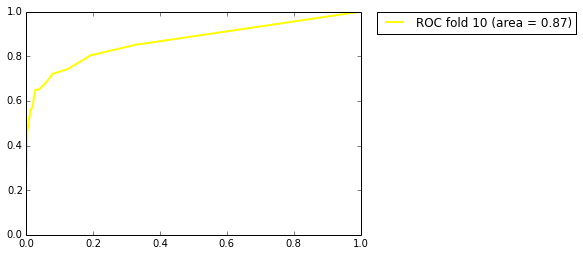

In [160]:
plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, current_auc))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [5]:
def write_output(filedescritor, results):
    f.write("Accuracy avg : {}\r\n".format(results[0]))
    f.write("AUC avg : {}\r\n".format(results[1]))
    f.write("  Sensitivity avg : {}\r\n".format(results[4]))
    f.write("  Specificity avg : {}\r\n".format(results[5]))
    f.write("AUPR avg : {}\r\n".format(results[2]))
    f.write("  Precision avg : {}\r\n".format(results[6]))
    f.write("  Recall avg : {}\r\n".format(results[7]))
    f.write("confusion amtrix : {}\r\n".format(results[3]))


Fri 23:10:14
120----------------------------------------------------



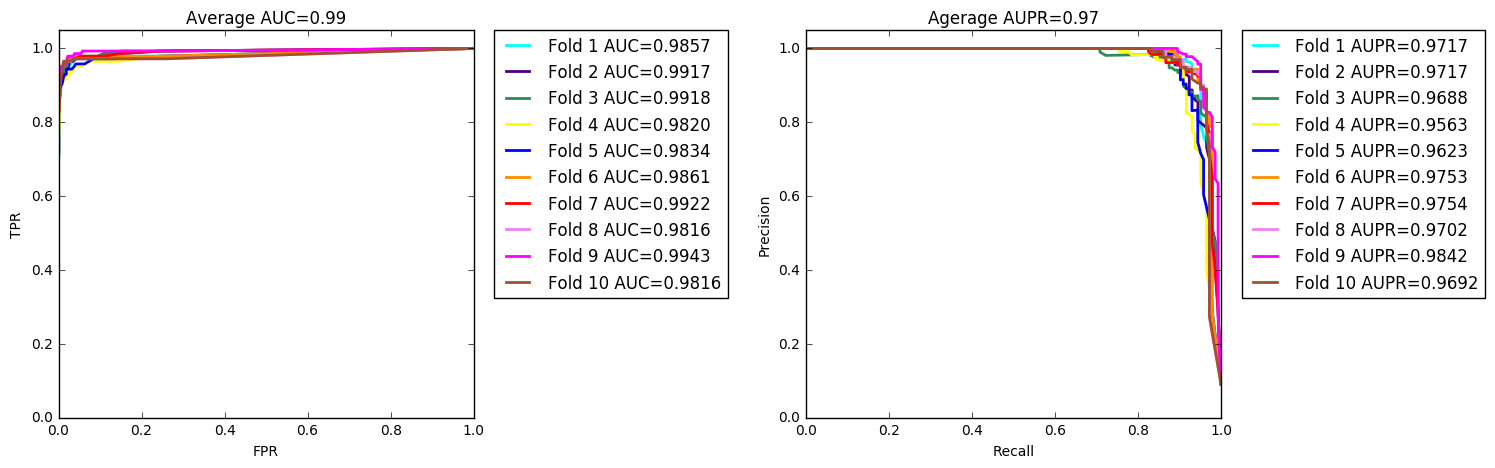

300----------------------------------------------------



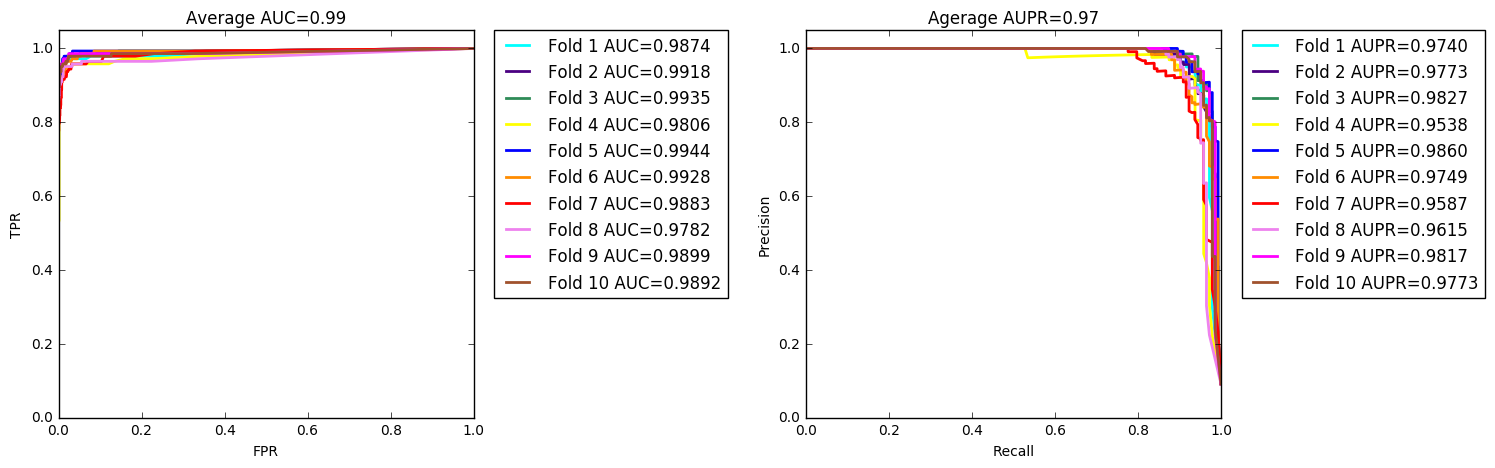

500----------------------------------------------------



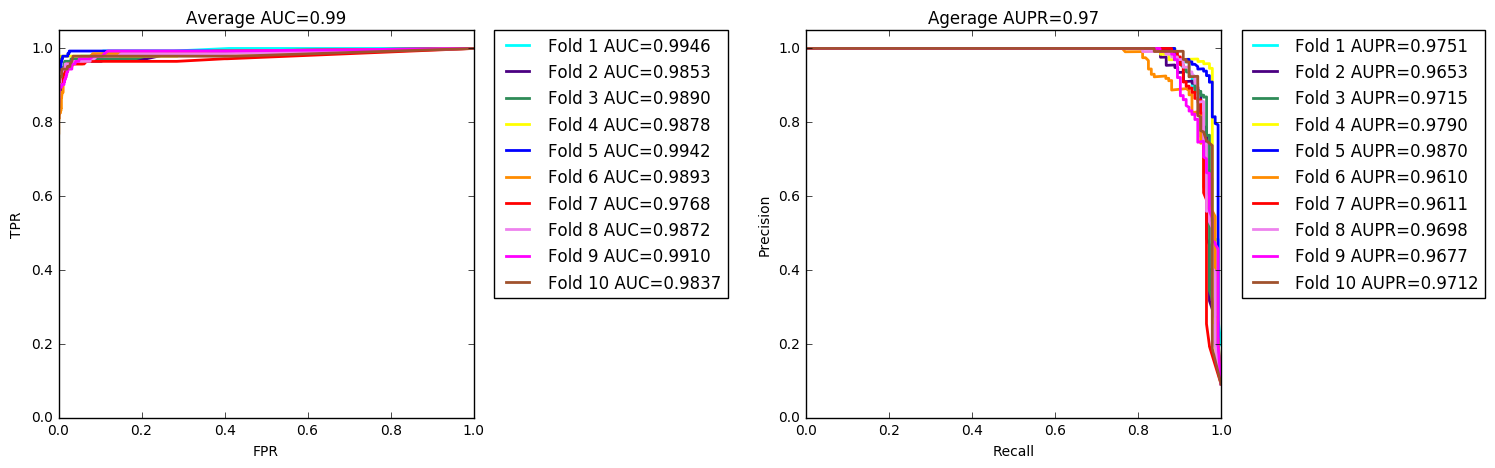

800----------------------------------------------------



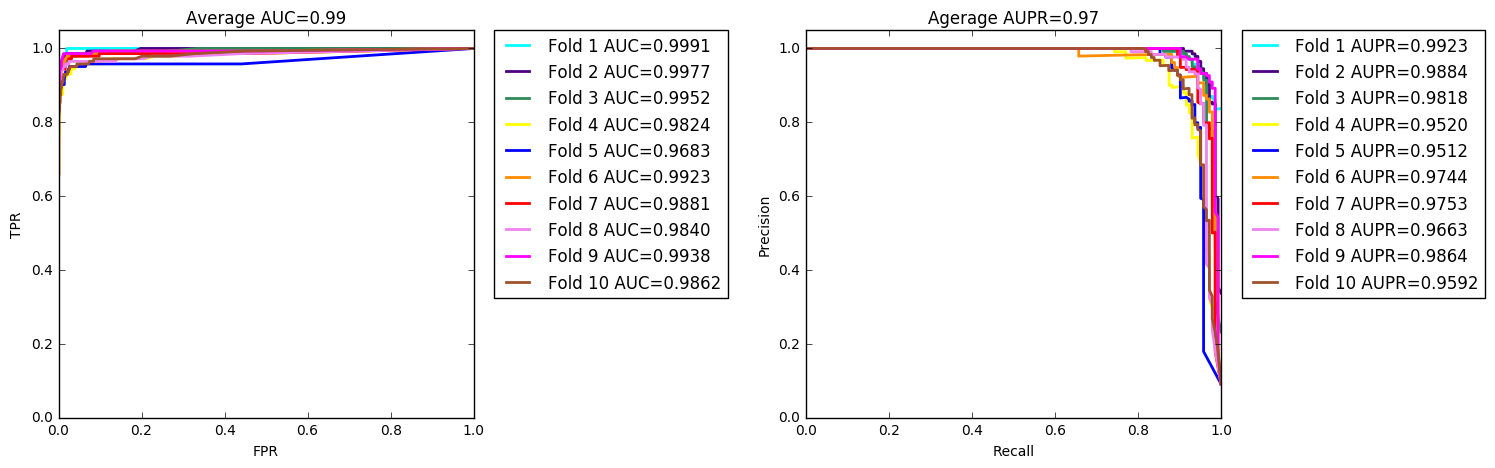

1200----------------------------------------------------



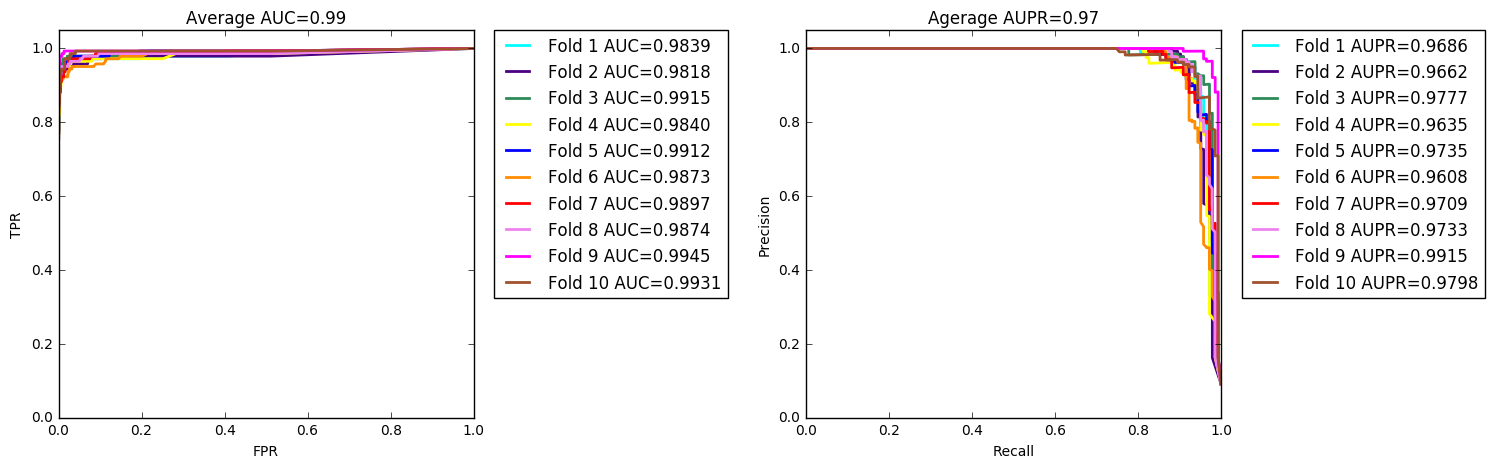

Fri 23:29:40


In [8]:
# removed descriptor, tn(whole) 10-fold, 2017.3.15. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/2_9_RF_removed_TN_whole_10-fold.txt", 'w') as f :
    for user_estimators in [120,300,500,800,1200]:
        results = Random_Forest_10_fold(x_whole_data, y_whole_data, user_estimators)
        f.write("{}----------------------------------------------------\r\n".format(user_estimators))
        write_output(f, results)
        
print time.strftime('%a %H:%M:%S')

Fri 22:26:24
120----------------------------------------------------



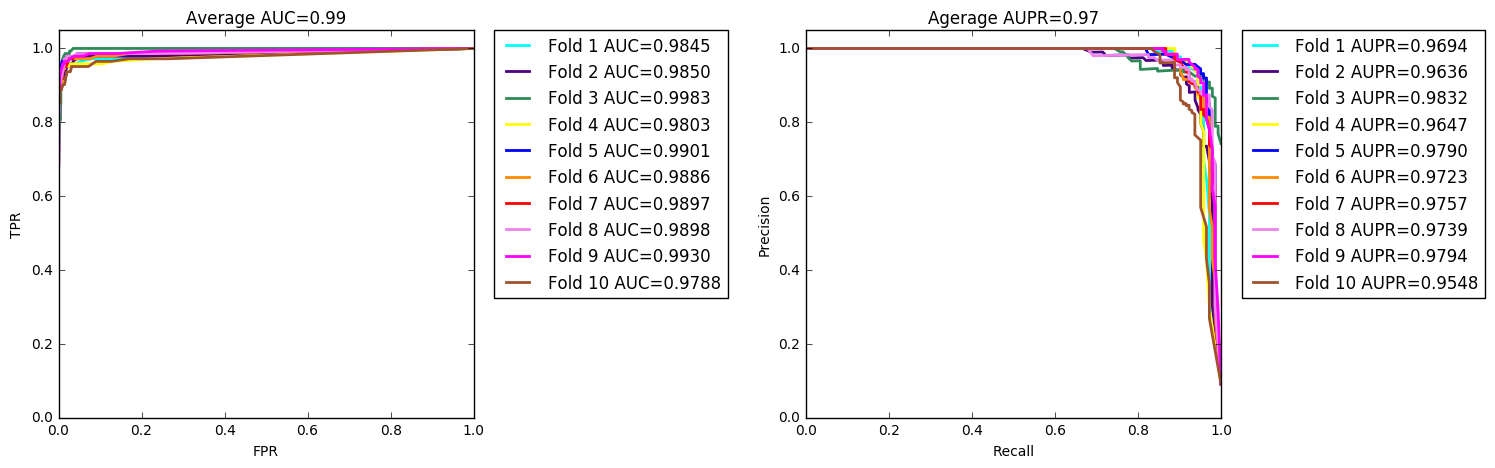

300----------------------------------------------------



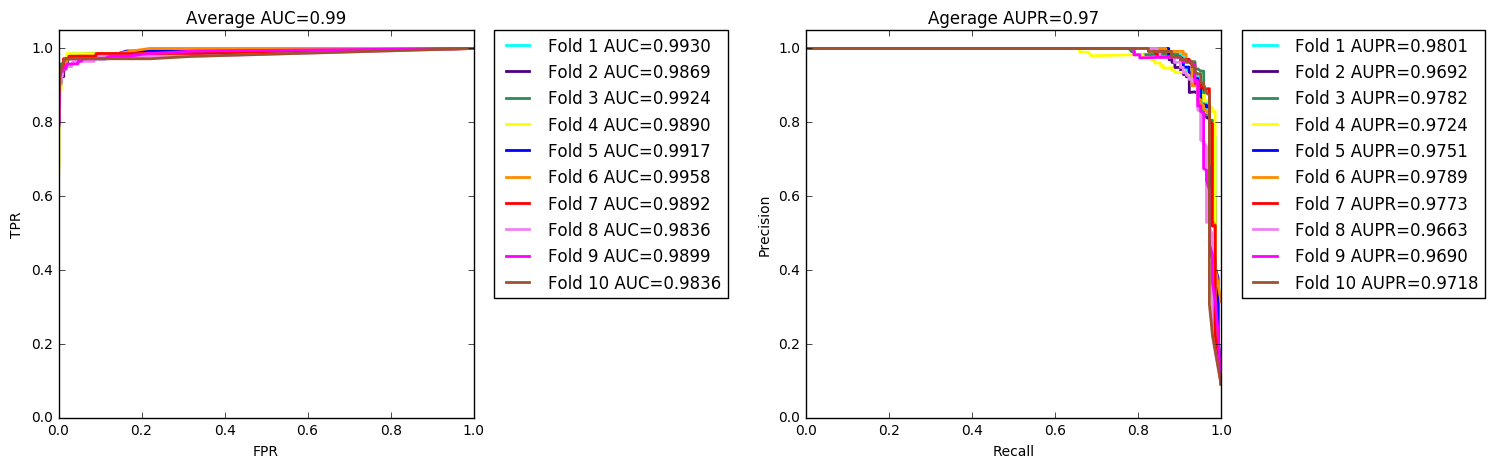

500----------------------------------------------------



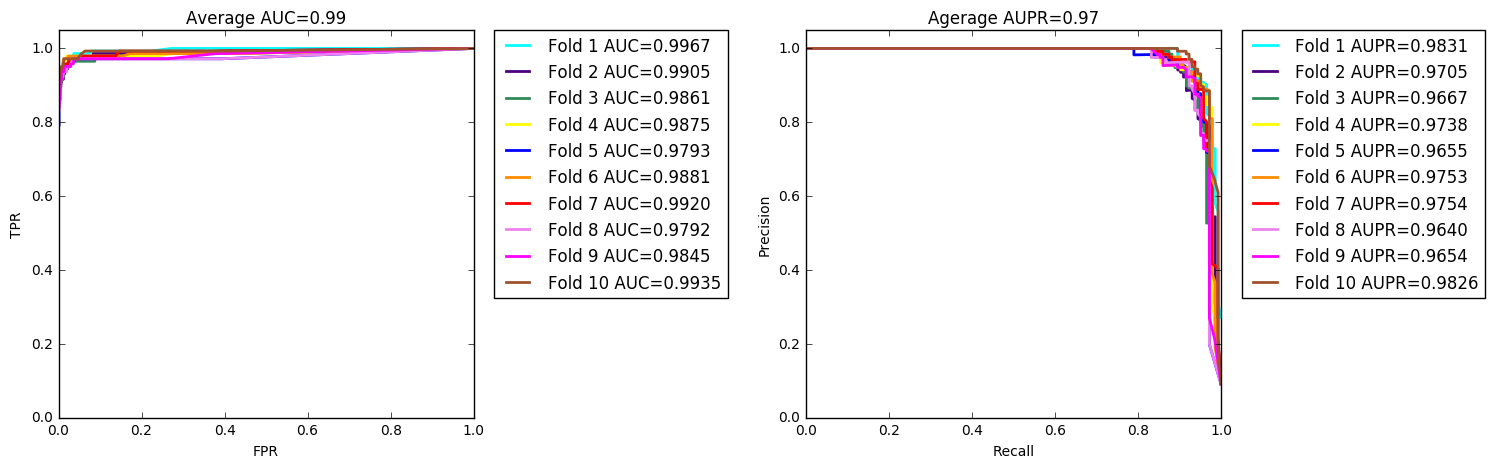

800----------------------------------------------------



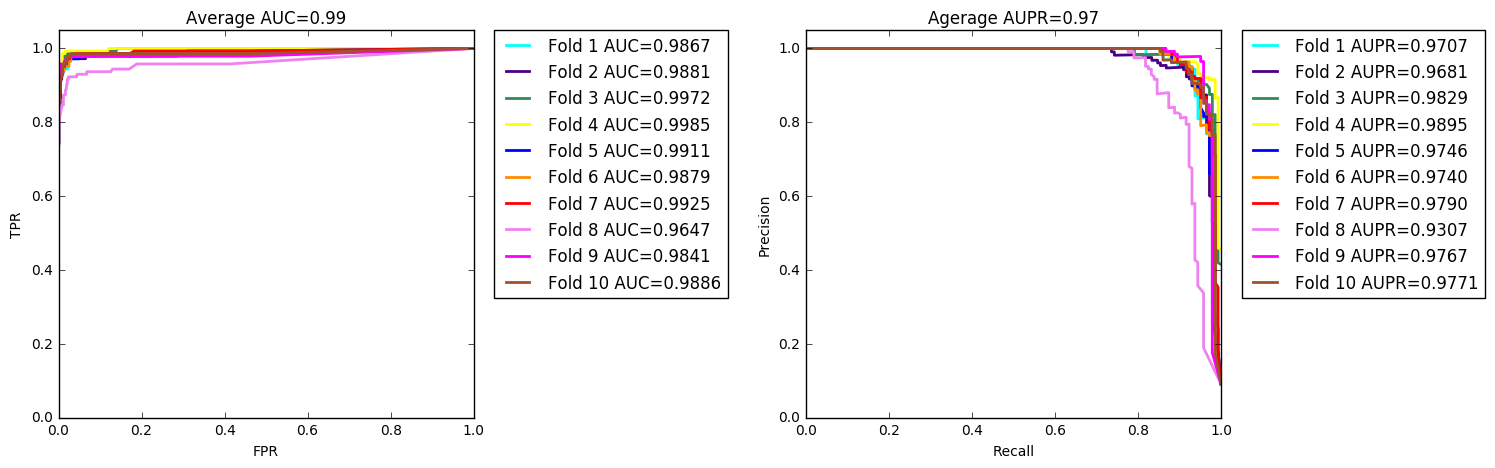

1200----------------------------------------------------



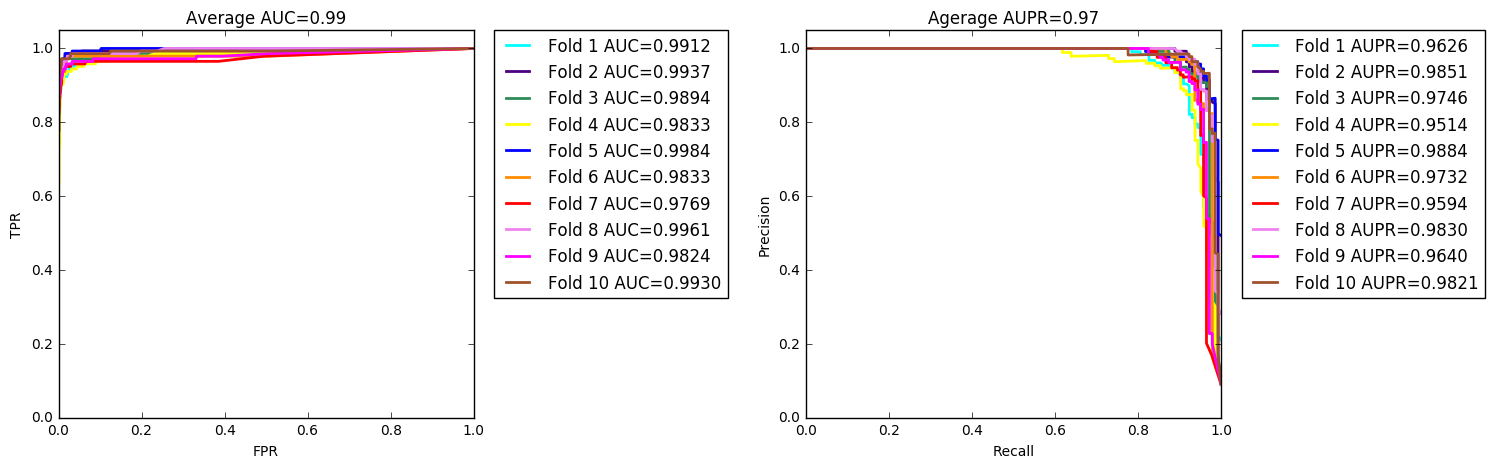

Fri 22:47:16


In [6]:
# 원래 descriptor, tn(whole) 10-fold, 2017.3.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/2_8_RF_original_TN_whole_10-fold.txt", 'w') as f :
    for user_estimators in [120,300,500,800,1200]:
        results = Random_Forest_10_fold(x_whole_data, y_whole_data, user_estimators)
        f.write("{}----------------------------------------------------\r\n".format(user_estimators))
        write_output(f, results)
        
print time.strftime('%a %H:%M:%S')

Thu 21:15:19
120----------------------------------------------------



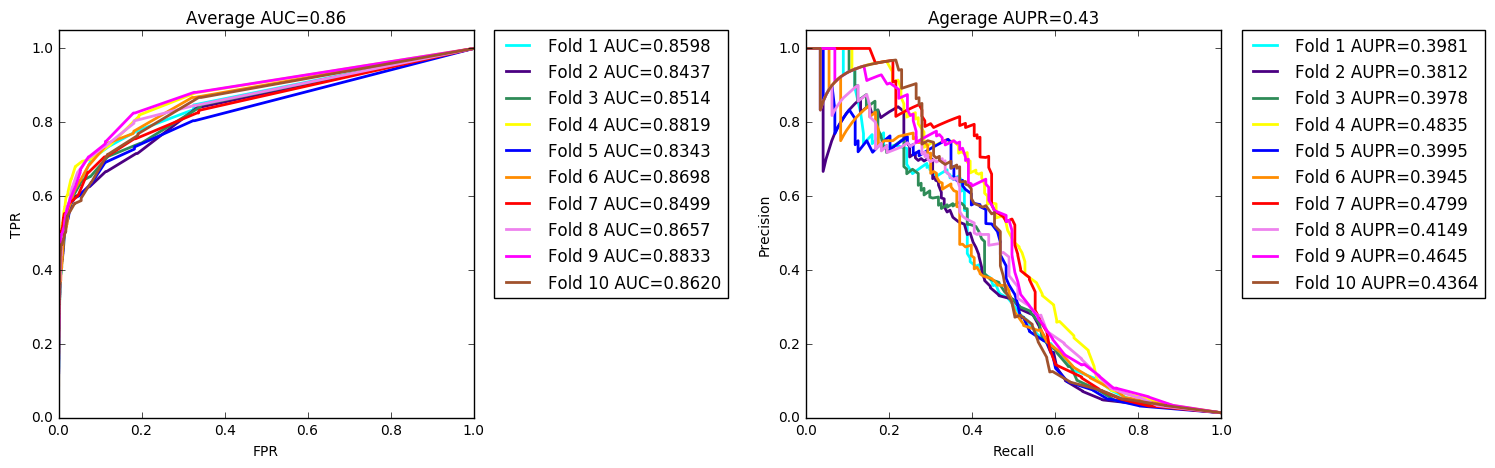

300----------------------------------------------------



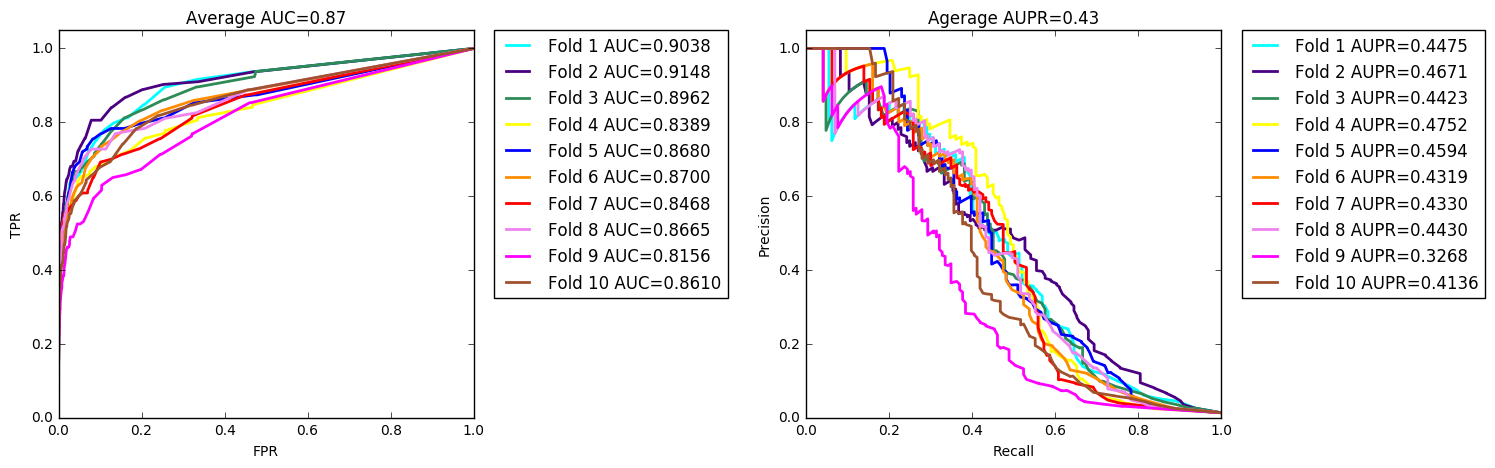

500----------------------------------------------------



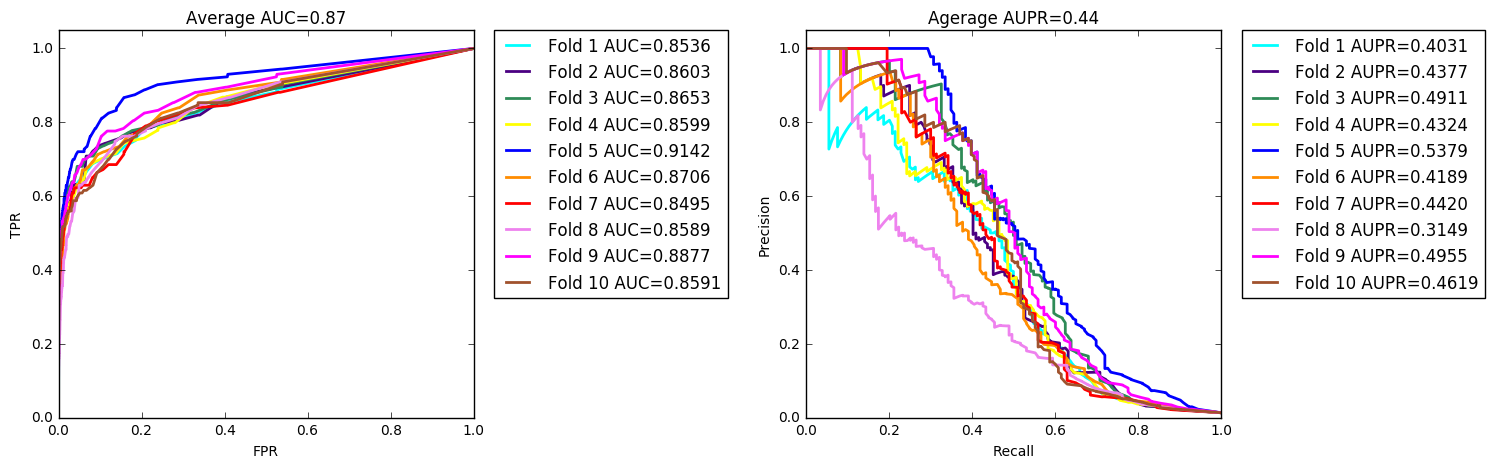

800----------------------------------------------------



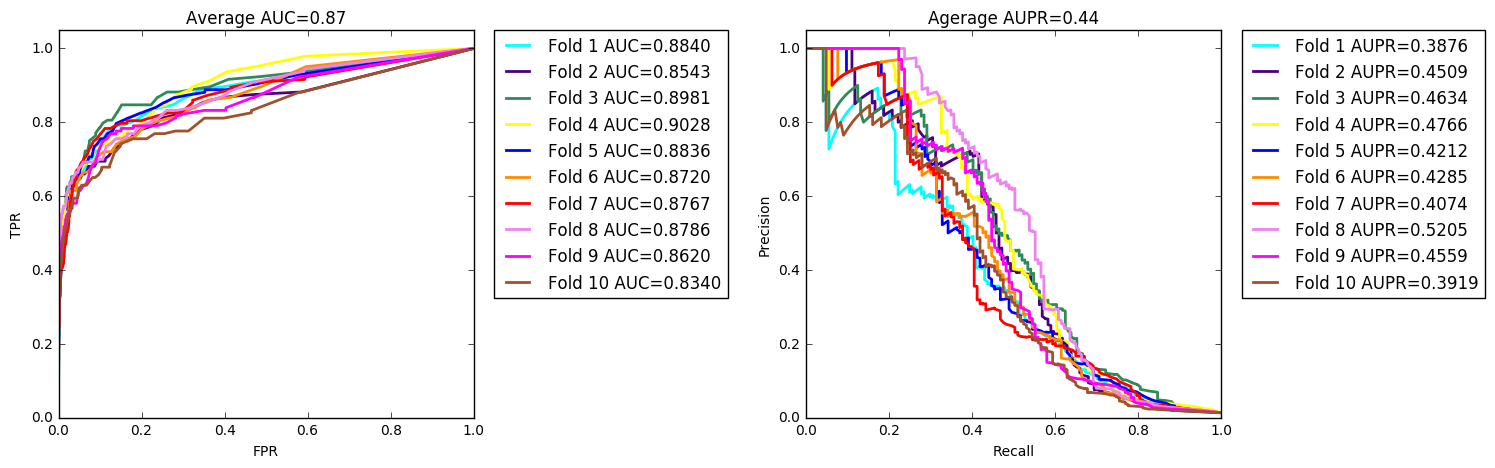

1200----------------------------------------------------



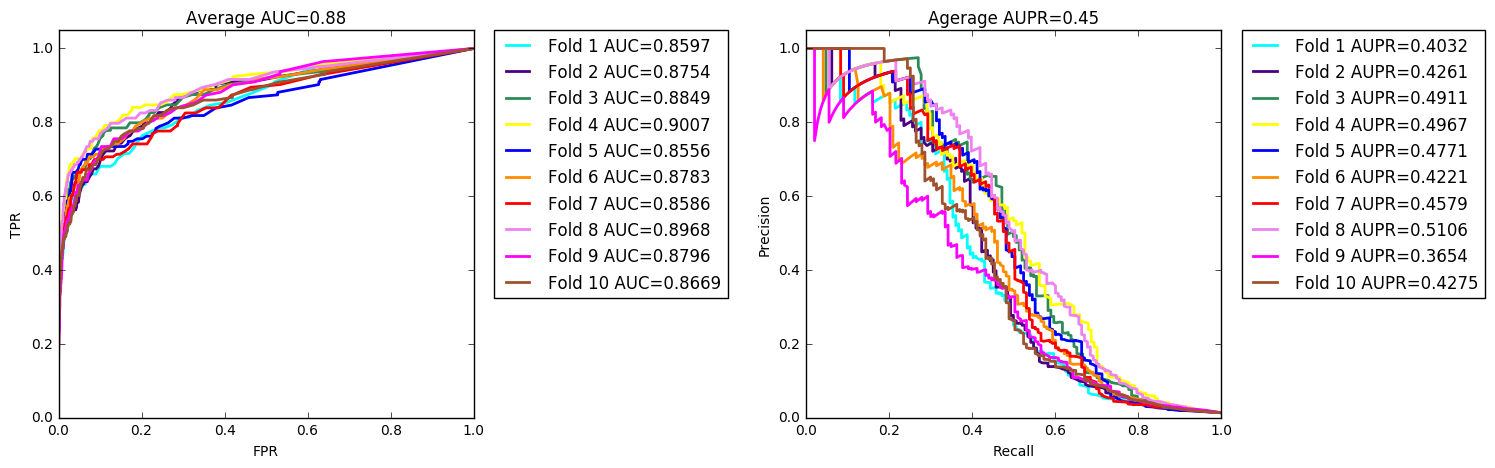

Thu 23:18:29


In [8]:
# new descriptor(independet에 맞춘거), 10-fold, 2017.3.9. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/2_6_RF_removed_10-fold.txt", 'w') as f :
    for user_estimators in [120,300,500,800,1200]:
        results = Random_Forest_10_fold(x_whole_data, y_whole_data, user_estimators)
        f.write("{}----------------------------------------------------\r\n".format(user_estimators))
        write_output(f, results)
        
print time.strftime('%a %H:%M:%S')

Fri 00:31:39


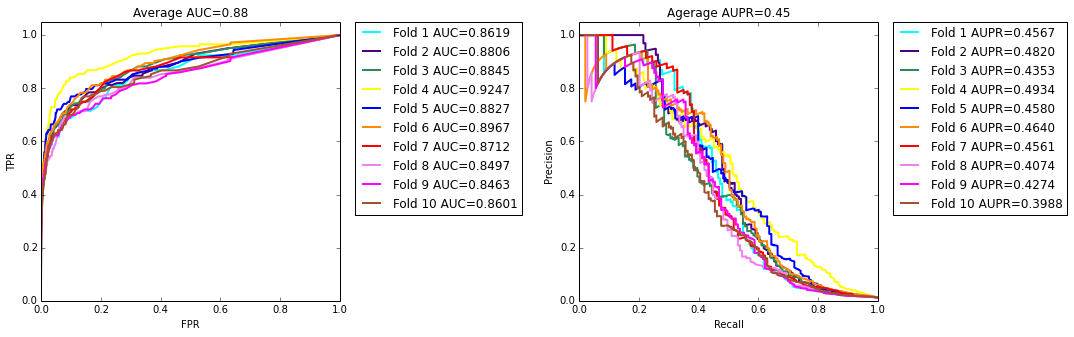

Fri 01:19:22


In [15]:
# 기존 dataset, 10-fold, 2017.2.14. 작성. #2017.2.23. 작성(sp, sn, recall, precision)
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/2_1_RF_orignal_10-fold2.txt", 'w') as f :
    #for user_estimators in [120,300,500,800,1200]:
    #    results = Random_Forest_10_fold(x_whole_data, y_whole_data, user_estimators)
    #    f.write("{}----------------------------------------------------\r\n".format(user_estimators))
    #    write_output(f, results)
    user_estimators = 1200
    results = Random_Forest_10_fold(x_whole_data, y_whole_data, user_estimators)
    f.write("{}----------------------------------------------------\r\n".format(user_estimators))
    write_output(f, results)
print time.strftime('%a %H:%M:%S')

Fri 02:01:37


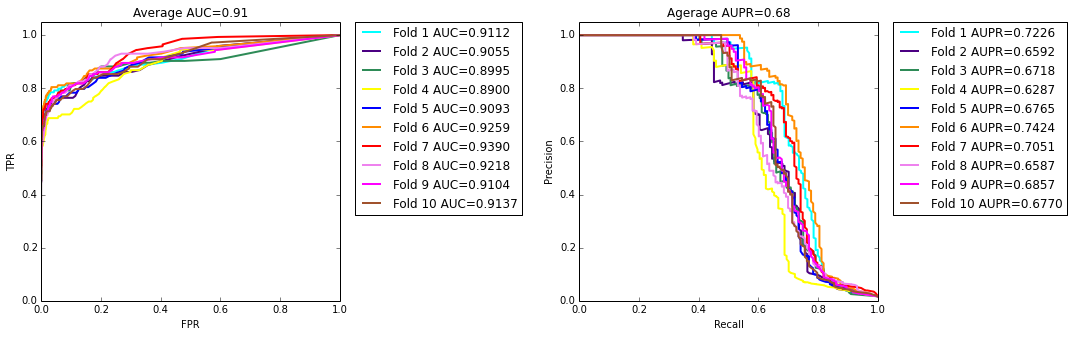

Fri 02:43:36


In [18]:
# 기존 dataset, 10-fold, 2017.2.14. 작성. #2017.2.23. 작성(sp, sn, recall, precision)
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/2_1_RF_0_1_10-fold_ver2.txt", 'w') as f :
    #for user_estimators in [120,300,500,800,1200]:
    #    results = Random_Forest_10_fold(x_whole_data, y_whole_data, user_estimators)
    #    f.write("{}----------------------------------------------------\r\n".format(user_estimators))
    #    write_output(f, results)
    user_estimators = 1200
    results = Random_Forest_10_fold(x_whole_data_0_1, y_whole_data_0_1, user_estimators)
    f.write("{}----------------------------------------------------\r\n".format(user_estimators))
    write_output(f, results)
print time.strftime('%a %H:%M:%S')

In [ ]:
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_0.1%.tsv")
x_whole_data_0_1 = df[df.columns.values[3:].tolist()].values
y_whole_data_0_1 = df["association"].values

In [ ]:
# undersampling dataset(1%), 10-fold, 2017.2.14. 작성.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/2_2_RF_feature_based(1%)_10-fold.txt", 'w') as f :
    for user_estimators in [120,300,500,800,1200]:
        results = Random_Forest_10_fold(x_whole_data_1, y_whole_data_1, user_estimators)
        f.write("{}----------------------------------------------------\r\n".format(user_estimators))
        write_output(f, results)
print time.strftime('%a %H:%M:%S')

In [ ]:
# undersampling dataset(1%), 10-fold, 2017.2.14. 작성.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/2_3_RF_featrue_based(0.5%)_10-fold.txt", 'w') as f :
    for user_estimators in [120,300,500,800,1200]:
        results = Random_Forest_10_fold(x_whole_data_0_5, y_whole_data_0_5, user_estimators)
        f.write("{}----------------------------------------------------\r\n".format(user_estimators))
        write_output(f, results)
print time.strftime('%a %H:%M:%S')

In [ ]:
# undersampling dataset(1%), 10-fold, 2017.2.14. 작성.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/2_4_RF_feature_based(0.1%)_10-fold.txt", 'w') as f :
    for user_estimators in [120,300,500,800,1200]:
        results = Random_Forest_10_fold(x_whole_data_0_1, y_whole_data_0_1, user_estimators)
        f.write("{}----------------------------------------------------\r\n".format(user_estimators))
        write_output(f, results)
print time.strftime('%a %H:%M:%S')

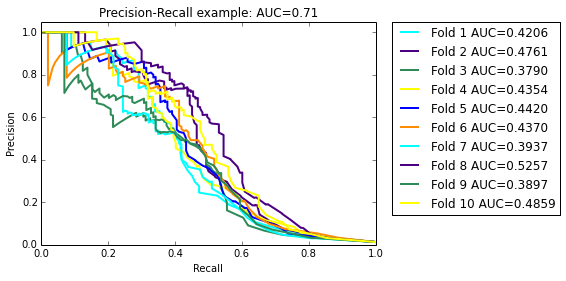

Accuracy avg : 0.989555955997
AUC avg : 0.861096086298
  Sensitivity avg : [ 0.99827004  0.32573815]

  Specificity avg : [ 0.32573815  0.99827004]

AUPR avg : 0.438510184679
  Precision avg : 0.712231507558

  Recall avg : 0.325738150738

Confustion matrix
[[109062    189]
 [   967    467]]


In [154]:
#### plot 하나만 그리기(AUPR)
skf = StratifiedKFold(n_splits=10, shuffle=True) # n_splits = 10 (10 fold라서.) data가 nega : pos = 76 : 1이기 때문에 validation 뽑을때 그 비율 지켜서 stratified로 한다.
whole_accuracy = list()
whole_auc = list()
whole_aupr = list()
whole_confusion_mat = list()
whole_precision = list()
whole_recall = list()
whole_sn = list()
whole_sp = list()
whole_precision_vec = list()
whole_recall_vec = list()
whole_predicted_proba = list()
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
lw = 2
plt.clf()
for (training_index, validation_index), color in zip(skf.split(x_whole_data, y_whole_data), colors):

    x_training_set = x_whole_data[training_index] # 0.9에 해당하는 부분
    y_training_set = y_whole_data[training_index]
    x_validation_set = x_whole_data[validation_index] # 0.1에 해당하는 부분
    y_validation_set = y_whole_data[validation_index]


    classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
    classifier.fit(x_training_set, y_training_set)
    y_predicted_proba = classifier.predict_proba(x_validation_set) # return값이 probability 각각에 대한 확률 결과값 [[0.8(0에대한 확률),0.2(1에대한 확률)],[0.7,0.3],... ]
    y_predicted_label = classifier.predict(x_validation_set) # return이 label임. 위 확률 결과에서 확률이 높은거에 대한 label을 보여줌.

    current_accuracy = classifier.score(x_validation_set, y_validation_set) # accuracy score를 보여줌.
    fpr, tpr, thresholds = roc_curve(y_validation_set, y_predicted_proba[:, 1], pos_label=1) # positive label만 본것., tpr = sensitivity, recall
    sn, sp, _ = sensitivity_specificity_support(y_validation_set, y_predicted_label)
    current_auc = auc(fpr, tpr)
    precision, recall, _, _ = precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
    current_aupr = average_precision_score(y_validation_set, y_predicted_proba[:, 1])
    current_confusion_matrix = confusion_matrix(y_validation_set,y_predicted_label)
    
    precision_vec, recall_vec, _ = precision_recall_curve(y_validation_set, y_predicted_proba[:, 1]) #전체 precision과 recall 보고 싶을때,
    
    lab = 'Fold %d AUC=%.4f' % (i+1, current_aupr)
    plt.plot(recall_vec, precision_vec, lw=lw, color=color, label=lab)
    i += 1
        
    whole_accuracy.append(current_accuracy)
    whole_auc.append(current_auc)
    whole_sn.append(sn)
    whole_sp.append(sp)
    whole_aupr.append(current_aupr)
    whole_precision.append(precision)
    whole_recall.append(recall)
    whole_confusion_mat.append((current_confusion_matrix))
    whole_precision_vec.append(precision_vec)
    whole_recall_vec.append(recall_vec)
    whole_predicted_proba.append(y_predicted_proba)
    # end of for loop
avg_acc = sum(whole_accuracy)/len(whole_accuracy)
avg_auc = sum(whole_auc)/len(whole_auc)
avg_aupr = sum(whole_aupr)/len(whole_aupr)
avg_sn = sum(whole_sn) / len(whole_sn)
avg_sp = sum(whole_sp) / len(whole_sp)
avg_precision = sum(whole_precision) / len(whole_precision)
avg_recall = sum(whole_recall) / len(whole_recall)
sum_confusion_matrix = sum(whole_confusion_mat)
precisions =  np.concatenate(whole_precision_vec)
recalls = np.concatenate(whole_recall_vec)
predicted_probas = np.concatenate(whole_predicted_proba)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(avg_precision))
#plt.legend(loc="lower left")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()


print("Accuracy avg : {}").format(sum(whole_accuracy)/len(whole_accuracy))
print("AUC avg : {}").format(sum(whole_auc)/len(whole_auc))
print("  Sensitivity avg : {}\r\n").format(sum(whole_sn)/len(whole_sn))
print("  Specificity avg : {}\r\n").format(sum(whole_sp)/len(whole_sp))
print("AUPR avg : {}").format(sum(whole_aupr)/len(whole_aupr))
print("  Precision avg : {}\r\n").format(sum(whole_precision)/len(whole_precision))
print("  Recall avg : {}\r\n").format(sum(whole_recall)/len(whole_recall))
print("Confustion matrix")
print(sum(whole_confusion_mat))


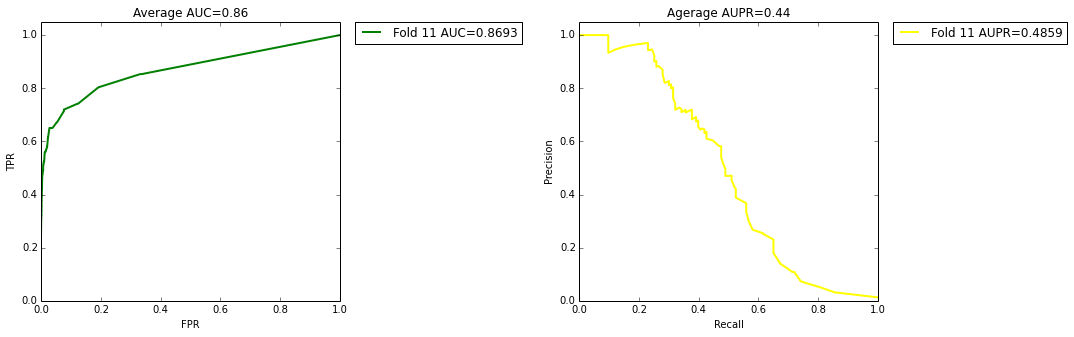

In [202]:
#### plot 2개 그리기 (한번만)

f, axes = plt.subplots(1, 2, figsize=(15, 5))
# plot AUC, AUPR
lab1 = 'Fold %d AUC=%.4f' % (i+1, current_auc)
lab2 = 'Fold %d AUPR=%.4f' % (i+1, current_aupr)
#plot.plot(recall_vec, precision_vec, lw=lw, color=color, label=lab)
axes[0].plot(fpr, tpr, lw=lw, color='green', label=lab1)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlim([0.0, 1.0])
axes[0].set_title('Average AUC={0:0.2f}'.format(avg_auc))
axes[1].plot(recall_vec, precision_vec, lw=lw, color=color, label=lab2)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlim([0.0, 1.0])
axes[1].set_title('Agerage AUPR={0:0.2f}'.format(avg_aupr))


f.subplots_adjust(wspace=0.8)


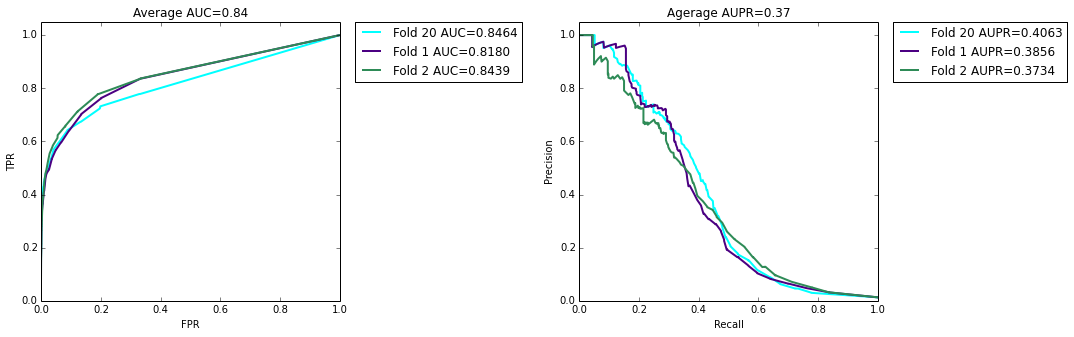

Accuracy avg : 0.988887383114
AUC avg : 0.837744790134
  Sensitivity avg : [ 0.99861786  0.24755927]

  Specificity avg : [ 0.24755927  0.99861786]

AUPR avg : 0.374907371835
  Precision avg : 0.702010064771

  Recall avg : 0.247559274756

Confustion matrix
[[109100    151]
 [  1079    355]]


In [204]:
#####plot 2개 그리기 (3-fold)

skf = StratifiedKFold(n_splits=3, shuffle=True) # n_splits = 10 (10 fold라서.) data가 nega : pos = 76 : 1이기 때문에 validation 뽑을때 그 비율 지켜서 stratified로 한다.
whole_accuracy = list()
whole_auc = list()
whole_aupr = list()
whole_confusion_mat = list()
whole_precision = list()
whole_recall = list()
whole_sn = list()
whole_sp = list()
whole_precision_vec = list()
whole_recall_vec = list()
whole_predicted_proba = list()
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
lw = 2
i=0
plt.clf()
f, axes = plt.subplots(1, 2, figsize=(15, 5))
for (training_index, validation_index), color in zip(skf.split(x_whole_data, y_whole_data), colors):

    x_training_set = x_whole_data[training_index] # 0.9에 해당하는 부분
    y_training_set = y_whole_data[training_index]
    x_validation_set = x_whole_data[validation_index] # 0.1에 해당하는 부분
    y_validation_set = y_whole_data[validation_index]


    classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
    classifier.fit(x_training_set, y_training_set)
    y_predicted_proba = classifier.predict_proba(x_validation_set) # return값이 probability 각각에 대한 확률 결과값 [[0.8(0에대한 확률),0.2(1에대한 확률)],[0.7,0.3],... ]
    y_predicted_label = classifier.predict(x_validation_set) # return이 label임. 위 확률 결과에서 확률이 높은거에 대한 label을 보여줌.

    current_accuracy = classifier.score(x_validation_set, y_validation_set) # accuracy score를 보여줌.
    fpr, tpr, thresholds = roc_curve(y_validation_set, y_predicted_proba[:, 1], pos_label=1) # positive label만 본것., tpr = sensitivity, recall
    sn, sp, _ = sensitivity_specificity_support(y_validation_set, y_predicted_label)
    current_auc = auc(fpr, tpr)
    precision, recall, _, _ = precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
    current_aupr = average_precision_score(y_validation_set, y_predicted_proba[:, 1])
    current_confusion_matrix = confusion_matrix(y_validation_set,y_predicted_label)
    precision_vec, recall_vec, _ = precision_recall_curve(y_validation_set, y_predicted_proba[:, 1]) #전체 precision과 recall 보고 싶을때,
    
    # plot AUC
    axes[0].plot(fpr, tpr, lw=lw, color=color, label=lab1)
    lab1 = 'Fold %d AUC=%.4f' % (i+1, current_auc)
    
    # plot AUPR
    axes[1].plot(recall_vec, precision_vec, lw=lw, color=color, label=lab2)
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, current_aupr)
    
    i += 1
        
    whole_accuracy.append(current_accuracy)
    whole_auc.append(current_auc)
    whole_sn.append(sn)
    whole_sp.append(sp)
    whole_aupr.append(current_aupr)
    whole_precision.append(precision)
    whole_recall.append(recall)
    whole_confusion_mat.append((current_confusion_matrix))
    
    # end of for loop
avg_acc = sum(whole_accuracy)/len(whole_accuracy)
avg_auc = sum(whole_auc)/len(whole_auc)
avg_aupr = sum(whole_aupr)/len(whole_aupr)
avg_sn = sum(whole_sn) / len(whole_sn)
avg_sp = sum(whole_sp) / len(whole_sp)
avg_precision = sum(whole_precision) / len(whole_precision)
avg_recall = sum(whole_recall) / len(whole_recall)
sum_confusion_matrix = sum(whole_confusion_mat)


axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlim([0.0, 1.0])
axes[0].set_title('Average AUC={0:0.2f}'.format(avg_auc))
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlim([0.0, 1.0])
axes[1].set_title('Agerage AUPR={0:0.2f}'.format(avg_aupr))
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
f.subplots_adjust(wspace=0.8)

plt.show()


print("Accuracy avg : {}").format(sum(whole_accuracy)/len(whole_accuracy))
print("AUC avg : {}").format(sum(whole_auc)/len(whole_auc))
print("  Sensitivity avg : {}\r\n").format(sum(whole_sn)/len(whole_sn))
print("  Specificity avg : {}\r\n").format(sum(whole_sp)/len(whole_sp))
print("AUPR avg : {}").format(sum(whole_aupr)/len(whole_aupr))
print("  Precision avg : {}\r\n").format(sum(whole_precision)/len(whole_precision))
print("  Recall avg : {}\r\n").format(sum(whole_recall)/len(whole_recall))
print("Confustion matrix")
print(sum(whole_confusion_mat))


In [128]:
plt.close() # will close the figure window entirely
plt.clf() # will just clear the figure - you can still paint another plot onto it.